# Overview

This notebook will perform the following tasks:

- define wrapper function to invoke LIDIA model for interactive inference
- analyze de-noise performance of LIDIA model with
  - synthetic data
  - real data (provided by Shiming)

## Wrapper for LIDIA

In [4]:
import sys
sys.path.append('../LIDIA-denoiser/code')

import torch
import numpy as np

from modules import (
    ArchitectureOptions,
    NonLocalDenoiser,
)

from utils import (
    calc_padding,
    process_image,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def denoise_with_lidia(input_img: np.ndarray, sigma: int) -> np.ndarray:
    """Wrapper for LIDIA denoiser.
    
    Parameters
    ----------
    input_img : np.ndarray
        Input image to be denoised.
    sigma : int
        Noise level.
        
    Returns
    -------
    np.ndarray
        Denoised image.

    NOTE
    ----
    This wrapper function is not optimized for production.
    It is adapted from LIDIA-denoiser/code/denoise_bw.py
    """
    # define the model
    arch_opt = ArchitectureOptions(rgb=False, small_network=False)
    pad_offs, _ = calc_padding(arch_opt)
    nl_denoiser = NonLocalDenoiser(pad_offs, arch_opt)
    nl_denoiser.cuda()

    # load the weight
    model_file_path = f"LIDIA-denoiser/models/model_state_sigma_{sigma}_bw.pt"
    model_state0 = torch.load(model_file_path)
    nl_denoiser.patch_denoise_net.load_state_dict(model_state0['state_dict'])

    # process the image
    rst_img = process_image(
        nl_denoiser,
        torch.from_numpy(input_img).to(device),
    ).cpu().numpy()

    return rst_img

## Case study: Shepp-Logan phantom 2D

In [6]:
import tomopy
from ntabpy.evaluator import tomo_round_trip_2d

In [7]:
image_size = 512
phantom = tomopy.misc.phantom.shepp2d(size=image_size)

Input Image:  0.0 255.0
Sinogram:  1e-08 1.0
Reconstruction:  -0.03454251 0.014884589
Gain Error:  0.58861864 1.3969102
Reconstruction of Gain Error:  -0.08379143 0.037704818


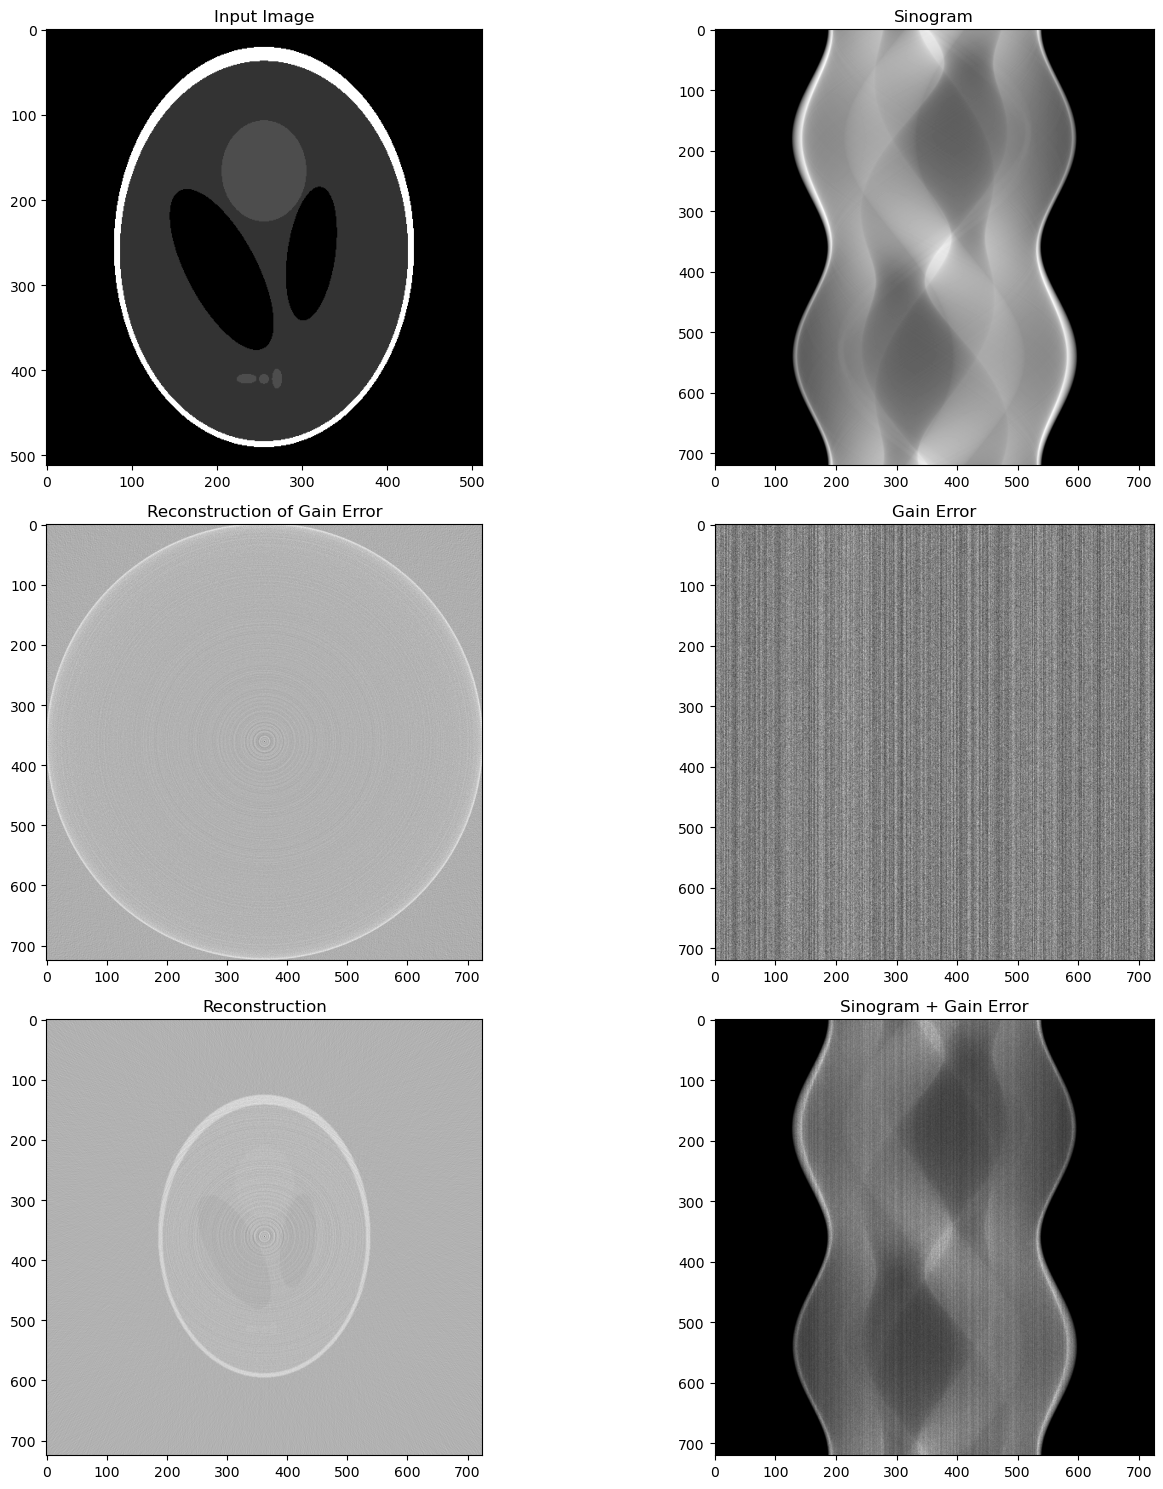

In [8]:
sino_shepp, recon_shepp, det_shepp, gain_shepp = tomo_round_trip_2d(
    phantom[0],
    scan_step=0.5,
    detector_gain_range=(0.9, 1.1),
    detector_gain_error=0.07,
    show_plot=True,
)